The module jupytext is used to treat this .py file as a jupyter notebook file. To keep the output after every session, go to "File" -> "Jupytext" -> "Pair Notebook with ipynb document". This generates a file PY_FILENAME.ipynb.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import math
import time
import datetime
from ignite.engine import Engine, Events
from ignite.metrics import InceptionScore, FID

In [2]:
if torch.cuda.is_available():
    print("Using GPU.")
    device = "cuda"
else:
    print("Using CPU.")
    device = "cpu"

Using GPU.


# Load MNIST Dataset

In [3]:
folder_path = "./data/mnist"

train_dataset = datasets.MNIST(root=folder_path, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=folder_path, train=False, transform=transforms.ToTensor(), download=True)

# Data Exploration

In [4]:
train_image_data = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()

assert (train_image_data.shape == np.array([60000, 28, 28])).all()
assert (train_labels.shape == np.array([60000,])).all()

In [5]:
def plot_images(images):
    """Plots up to 9 images."""
    amount_images_to_show = min(9, images.shape[0])
    grid_shape = np.array([3, 3])
    for image_index in range(amount_images_to_show):
        plt.subplot(grid_shape[0], grid_shape[1], image_index + 1)
        plt.xticks([])
        plt.yticks([])
        image_to_show = images[image_index]
        plt.imshow(image_to_show, cmap="gray")
    plt.show()

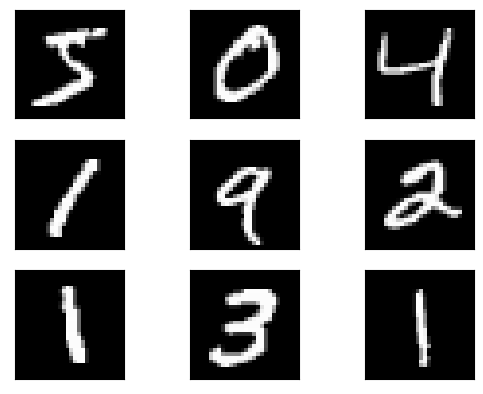

In [6]:
plot_images(train_image_data)

In [7]:
assert (train_labels[:9] == np.array([5, 0, 4, 1, 9, 2, 1, 3, 1])).all()

# Forward Noise Process

In [8]:
def add_noise(images, beta):
    alpha = 1 - beta
    alpha_cum = torch.prod(alpha)
    noise = torch.randn(images.shape).to(device)
    noisy_images = noise * (1 - alpha_cum) + torch.sqrt(alpha_cum) * images
    noisy_images = noisy_images.to(device)
    return noisy_images

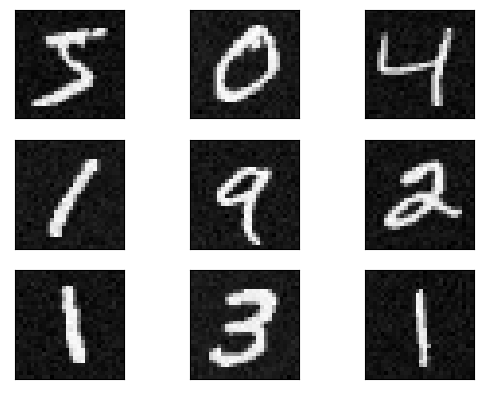

In [9]:
variances = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]).to(device)
noisy_images = add_noise(train_dataset.data.to(device), variances).cpu()
plot_images(noisy_images)

In [10]:
variances = torch.Tensor(np.linspace(1e-4, 1e-2, 1000)).to(device)

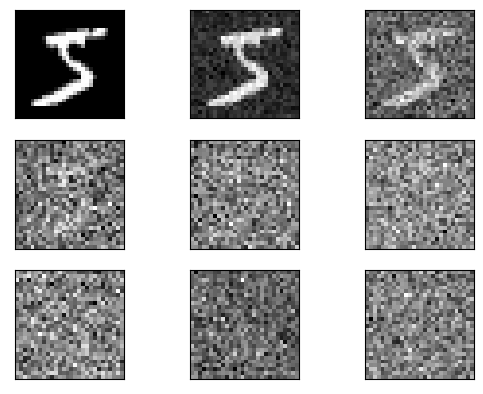

In [11]:
image = train_dataset.data[0].numpy()
transformer = transforms.ToTensor()
image = transformer(image).to(device)
noisy_images = torch.zeros([9, *image.shape])
for i in range(9):
    index_stepsize = (variances.shape[0] - 1) / 8
    timestep = int(i * index_stepsize) + 1
    noisy_image = add_noise(image, variances[:timestep])
    noisy_images[i] = noisy_image
plot_images(noisy_images.permute(0, 2, 3, 1).numpy())

# Noise Prediction Model Implementation
Uses a UNET architecture to predict the noise of given noisy images.

In [12]:
class MNISTConditionalEmbeddingLayer(nn.Module):
    def __init__(self, cond_emb_dim):
        super(MNISTConditionalEmbeddingLayer, self).__init__()
        self.cond_emb_dim = cond_emb_dim
        self.amount_unique_classes = 10
        self.linear_layer = nn.Linear(self.amount_unique_classes, self.cond_emb_dim)
        self.relu = nn.ReLU()
        
    def forward(self, c):
        c = nn.functional.one_hot(c, self.amount_unique_classes).float().to(device)
        c = self.linear_layer(c)
        c = self.relu(c)
        return c
        
        
class ResidualConv2dBlock(nn.Module):
    def __init__(self, amount_channels_input, amount_channels_output, time_emb_dim, cond_emb_dim):
        super(ResidualConv2dBlock, self).__init__()
        self.time_emb_mlp = nn.Sequential(nn.Linear(time_emb_dim, amount_channels_input),
                                            nn.ReLU())
        self.layers = nn.Sequential(nn.Conv2d(amount_channels_input, amount_channels_output, 3, padding=1),
                                    nn.GroupNorm(2, amount_channels_output),
                                    nn.ReLU(),
                                    nn.Conv2d(amount_channels_output, amount_channels_output, 3, padding=1),
                                    nn.GroupNorm(2, amount_channels_output),
                                    nn.ReLU())
        self.residual_layer = nn.Conv2d(amount_channels_input, amount_channels_output, 1)
        self.cond_emb_mlp = nn.Sequential(nn.Linear(cond_emb_dim, amount_channels_input),
                                            nn.ReLU())

    def forward(self, x, t, c):
        t = self.time_emb_mlp(t)
        t = t[(..., ) + (None, ) * 2]
        x = x + t
        
        if c is not None:
            c = self.cond_emb_mlp(c)
            c = c[(..., ) + (None, ) * 2]
            x = x + c
            
        conv_output = self.layers(x)
        residual_output = self.residual_layer(x)
        return conv_output + residual_output

class ApplyAttentionBlock(nn.Module):
    def __init__(self, amount_channels, amount_channels_attention):
        super(ApplyAttentionBlock, self).__init__()
        self.amount_channels_attention = amount_channels_attention
        self.query_conv2d = nn.Conv2d(amount_channels, self.amount_channels_attention, 1)
        self.keys_conv2d = nn.Conv2d(amount_channels, self.amount_channels_attention, 1)
        self.values_conv2d = nn.Conv2d(amount_channels, self.amount_channels_attention, 1)
        self.attention_conv2d = nn.Conv2d(self.amount_channels_attention, amount_channels, 1)
        self.group_norm = nn.GroupNorm(2, amount_channels)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        residual = x
        original_shape = x.shape

        query = self.query_conv2d(x).flatten(start_dim=-2, end_dim=-1).permute(0, 2, 1)
        keys = self.keys_conv2d(x).flatten(start_dim=-2, end_dim=-1)
        values = self.values_conv2d(x).flatten(start_dim=-2, end_dim=-1)

        x = torch.matmul(query, keys)
        x = self.softmax(x)
        x = x.permute(0, 2, 1)
        x = torch.matmul(values, x)

        x = x.permute(0, 2, 1).reshape(original_shape[0], self.amount_channels_attention, original_shape[2], original_shape[3])
        x = self.attention_conv2d(x)
        x = self.group_norm(x)
        x = self.relu(x)
        
        x = x + residual
        return x

class UnetConv2dBlock(nn.Module):
    def __init__(self, amount_channels_input, amount_channels_output, time_emb_dim, cond_emb_dim, use_attention=False):
        super(UnetConv2dBlock, self).__init__()
        self.block1 = ResidualConv2dBlock(amount_channels_input, amount_channels_output, time_emb_dim, cond_emb_dim)
        self.block2 = ResidualConv2dBlock(amount_channels_output, amount_channels_output, time_emb_dim, cond_emb_dim)
        self.attention_block = None
        if use_attention:
            amount_channels_attention = amount_channels_output
            self.attention_block = ApplyAttentionBlock(amount_channels_output, amount_channels_attention)

    def forward(self, x, t, c):
        x = self.block1(x, t, c)
        if self.attention_block is not None:
            x = self.attention_block(x)
        x = self.block2(x, t, c)
        return x
    
class EncoderBlock(nn.Module):
    def __init__(self, amount_channels_input, amount_channels_output, time_emb_dim, cond_emb_dim, use_attention=False):
        super(EncoderBlock, self).__init__()
        self.conv_block = UnetConv2dBlock(amount_channels_input, amount_channels_output, time_emb_dim, cond_emb_dim, use_attention)
        self.downsampling_layer = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
    def forward(self, x, t, c):
        x = self.conv_block(x, t, c)
        skip_values = x
        x = self.downsampling_layer(x)
        x = self.relu(x)
        return x, skip_values

class DecoderBlock(nn.Module):
    def __init__(self, amount_channels_input, amount_channels_output, time_emb_dim, cond_emb_dim, use_attention=False):
        super(DecoderBlock, self).__init__()
        self.conv_block = UnetConv2dBlock(amount_channels_output * 2, amount_channels_output, time_emb_dim, cond_emb_dim, use_attention)
        self.upsampling_layer = nn.ConvTranspose2d(amount_channels_input, amount_channels_output, 2, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x, t, skip_values, c):
        x = self.upsampling_layer(x)
        x = self.relu(x)
        x = torch.cat([x, skip_values], axis=1)
        x = self.conv_block(x, t, c)
        return x

class SinusoidalPositionEmbeddingLayer(nn.Module):
    def __init__(self, time_emb_dim):
        super(SinusoidalPositionEmbeddingLayer, self).__init__()
        self.time_emb_dim = time_emb_dim

    def forward(self, timesteps):
        half_dim = self.time_emb_dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim).to(device) * -embeddings).to(device)
        embeddings = timesteps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1).to(device)
        return embeddings

class NoisePredictionUnet(nn.Module):
    def __init__(self, amounts_channels):
        super(NoisePredictionUnet, self).__init__()
        self.time_emb_dim = 32
        self.cond_emb_dim = 32
        
        encoder_blocks = []
        decoder_blocks = []
        layers_between = []
        final_layers = []
        self.divisor = 2 ** (len(amounts_channels) - 2)

        for i, current_amount_channels in enumerate(amounts_channels):
            next_amount_channels = amounts_channels[i + 1]
            if i == 0:
                final_layers.append(nn.Conv2d(next_amount_channels, current_amount_channels, 1))

                encoding_amount_channels_input = current_amount_channels
                encoding_amount_channels_output = next_amount_channels
                
                assert encoding_amount_channels_input <= encoding_amount_channels_output
                
                encoder_block = EncoderBlock(encoding_amount_channels_input, encoding_amount_channels_output, self.time_emb_dim, self.cond_emb_dim, True)
                encoder_blocks.append(encoder_block)
                
            elif i == len(amounts_channels) - 2:
                layers_between.append(UnetConv2dBlock(current_amount_channels, next_amount_channels, self.time_emb_dim, self.cond_emb_dim))
                
                decoding_amount_channels_input = next_amount_channels
                decoding_amount_channels_output = current_amount_channels
                
                assert decoding_amount_channels_input >= decoding_amount_channels_output
                
                decoder_block = DecoderBlock(decoding_amount_channels_input, decoding_amount_channels_output, self.time_emb_dim, self.cond_emb_dim, True)
                decoder_blocks.insert(0, decoder_block)
                break
            else:                
                encoding_amount_channels_input = current_amount_channels
                encoding_amount_channels_output = next_amount_channels
                
                decoding_amount_channels_input = next_amount_channels
                decoding_amount_channels_output = current_amount_channels

                assert encoding_amount_channels_input <= encoding_amount_channels_output
                assert decoding_amount_channels_input >= decoding_amount_channels_output
                
                encoder_block = EncoderBlock(encoding_amount_channels_input, encoding_amount_channels_output, self.time_emb_dim, self.cond_emb_dim, True)
                encoder_blocks.append(encoder_block)
                
                decoder_block = DecoderBlock(decoding_amount_channels_input, decoding_amount_channels_output, self.time_emb_dim, self.cond_emb_dim, True)
                decoder_blocks.insert(0, decoder_block)
                
        layers = encoder_blocks + layers_between + decoder_blocks + final_layers
        
        self.module_list = nn.ModuleList(layers)
        self.time_emb_mlp = nn.Sequential(SinusoidalPositionEmbeddingLayer(self.time_emb_dim),
                                            nn.Linear(self.time_emb_dim, self.time_emb_dim),
                                            nn.ReLU())
        self.cond_emb_mlp = nn.Sequential(MNISTConditionalEmbeddingLayer(self.cond_emb_dim),
                                            nn.Linear(self.cond_emb_dim, self.cond_emb_dim),
                                            nn.ReLU())

    def apply_padding(self, x):
        pad_width = self.divisor - x.shape[3] % self.divisor
        pad_height = self.divisor - x.shape[2] % self.divisor
        
        pad_left = int(pad_width / 2)
        pad_right = pad_width - pad_left
        
        pad_up = int(pad_height / 2)
        pad_down = pad_height - pad_up
        padding = (pad_left, pad_right, pad_up, pad_down)
        x = torch.nn.functional.pad(x, padding, mode='constant', value=0)
        return x, padding
        
    def undo_padding(self, x, padding):
        (pad_left, pad_right, pad_up, pad_down) = padding
        return x[:, :, pad_left:-pad_right, pad_up:-pad_down]
    
    def forward(self, x, t, c):
        skip_values = []
        t = self.time_emb_mlp(t)
        x, padding = self.apply_padding(x)

        if c is not None:
            c = self.cond_emb_mlp(c)
        for layer in self.module_list:
            if isinstance(layer, EncoderBlock):
                x, skip_value = layer(x, t, c)
                skip_values.append(skip_value)
            elif isinstance(layer, DecoderBlock):
                skip_value = skip_values.pop()
                x = layer(x, t, skip_value, c)
            elif isinstance(layer, UnetConv2dBlock):
                x = layer(x, t, c)
            else:
                x = layer(x)
                
        x = self.undo_padding(x, padding)
        assert len(skip_values) == 0
        return x

In [13]:
def get_loss(predicted_noise, expected_noise):
    mse_loss = nn.MSELoss().to(device)
    loss = mse_loss(predicted_noise, expected_noise)
    return loss

# Training

In [14]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
amount_batches_train = round(np.ceil(train_dataset.data.shape[0] / batch_size))
amount_batches_test = round(np.ceil(test_dataset.data.shape[0] / batch_size))

In [21]:
model = NoisePredictionUnet([1, 2, 4, 8, 16, 32]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## Sampling

In [16]:
def denoising_process(images, beta, noise_predictor, labels=None, simple_variance=True):
    "sample image"
    
    images_size = images.shape
    timesteps = beta.shape[0] - 1
    alpha = 1 - beta
    alpha_cum = torch.cumprod(alpha, dim=0).to(device)
    if simple_variance:
        variances = beta
    else:
        alpha_cum_t_minus_1 = torch.cat([torch.Tensor([0]).to(device), alpha_cum[:-1]], axis=0).to(device)
        variances = (1-alpha_cum_t_minus_1)/(1-alpha_cum) 
        variances = variances * beta
    
    variances = variances.to(device)
    x_t = images.to(device)

    with torch.no_grad():
        for timestep in range(timesteps, 0, -1):
            predicted_noise = noise_predictor(x_t, torch.ones(x_t.shape[0]).to(device) * timestep, labels)
            z = torch.normal(torch.zeros(images_size), torch.ones(images_size))

            if timestep == 1:
                z = torch.zeros(images_size)

            z = z.to(device)
            mean = (x_t - (1 - alpha[timestep]) / torch.sqrt(1 - alpha_cum[timestep]) * predicted_noise) \
                    / torch.sqrt(alpha[timestep])
            std = torch.sqrt(variances[timestep])
            x_t = (std * z + mean).to(device)

    # Normalizes to [0, 1] instead of [-1, 1].
    x_t = (x_t + 1) / 2
    return x_t

In [17]:
def get_training_data_single_timestep(images, variances):
    # Normalizes to [-1, 1] instead of [0, 1].
    images = images * 2 - 1
    batch_size = images.shape[0]
    
    sampled_timestep = np.random.randint(1, variances.shape[0] + 1)
    selected_variances = variances[:sampled_timestep]
    alpha_cum = torch.prod(1 - selected_variances, dim=0)

    expected_noise = torch.randn(images.shape).to(device)
    noisy_images = expected_noise * (1 - alpha_cum) + torch.sqrt(alpha_cum) * images
        
    timesteps = torch.ones(batch_size).int().to(device) * sampled_timestep
    return noisy_images, timesteps, expected_noise

In [18]:
def get_test_loss():
    mean_test_loss = 0
    with torch.no_grad():
        batch_test_losses = []
        for batch_index, test_data_batch in enumerate(test_loader):
            images, labels = test_data_batch
            images = images.to(device)
            noisy_images, timesteps, expected_noise = get_training_data_single_timestep(images, variances)
            predicted_noise = model(noisy_images, timesteps, labels)
            loss = get_loss(predicted_noise, expected_noise)
            batch_test_losses.append(loss.item())
        mean_test_loss = np.mean(batch_test_losses)
        print(f"Average Test Loss: {mean_test_loss}")
        print("")
    return mean_test_loss

def evaluate_model_results():
    data_batch, labels = next(iter(test_loader))

    if data_batch.shape[0] > 9:
        data_batch = data_batch[:9]

    noisy_images = add_noise(data_batch.to(device), variances)
    labels = labels.to(device)
    denoised_images = denoising_process(noisy_images, variances, model, labels).cpu().permute(0, 2, 3, 1).numpy()

    for i, image in enumerate(denoised_images):
        plt.subplot(1, 9, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap="gray")
    plt.show()

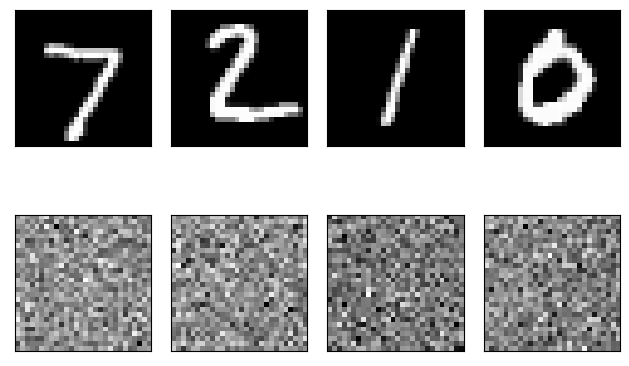

In [19]:
data_batch, _ = next(iter(test_loader))
if data_batch.shape[0] > 9:
    data_batch = data_batch[:9]

amount_images = data_batch.shape[0]

sample_images = data_batch.permute(0, 2, 3, 1).numpy()
noisy_images = add_noise(data_batch.to(device), variances).cpu().permute(0, 2, 3, 1).numpy()

for i, image in enumerate(sample_images):
    plt.subplot(2, amount_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap="gray")

    plt.subplot(2, amount_images, i + amount_images + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = noisy_images[i]
    plt.imshow(noisy_image, cmap="gray")
plt.tight_layout()
plt.show()

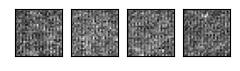

                                                                                          
Epoch 1:
Average Training Loss: 0.4835505355971555
Average Test Loss: 0.17746522543877363

                                                                                          
Epoch 2:
Average Training Loss: 0.1524205860859404
Average Test Loss: 0.13911320362240076

                                                                                          
Epoch 3:
Average Training Loss: 0.12983571442520866
Average Test Loss: 0.120800888780877

                                                                                          
Epoch 4:
Average Training Loss: 0.1209849293064947
Average Test Loss: 0.11532273123301566



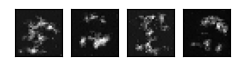

                                                                                          
Epoch 5:
Average Training Loss: 0.11713211464143047
Average Test Loss: 0.11163419397175312

                                                                                          
Epoch 6:
Average Training Loss: 0.10836655665996174
Average Test Loss: 0.10606947212703526

                                                                                          
Epoch 7:
Average Training Loss: 0.10492584940257171
Average Test Loss: 0.10222818624600769

                                                                                          
Epoch 8:
Average Training Loss: 0.10069341343489165
Average Test Loss: 0.10831143072228878



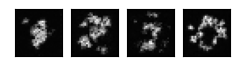

                                                                                          
Epoch 9:
Average Training Loss: 0.09796633268970376
Average Test Loss: 0.09682586890310049

                                                                                          
Epoch 10:
Average Training Loss: 0.09600175862324735
Average Test Loss: 0.092973515448533

                                                                                          
Epoch 11:
Average Training Loss: 0.09489511197206253
Average Test Loss: 0.0943596962844953

                                                                                          
Epoch 12:
Average Training Loss: 0.09345321195044866
Average Test Loss: 0.09366697954442352



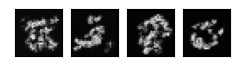

                                                                                          
Epoch 13:
Average Training Loss: 0.09263027748788397
Average Test Loss: 0.09073378318753093

                                                                                          
Epoch 14:
Average Training Loss: 0.0923219343268002
Average Test Loss: 0.08765198474302888

                                                                                          
Epoch 15:
Average Training Loss: 0.09361497754979257
Average Test Loss: 0.09251263303216546

                                                                                          
Epoch 16:
Average Training Loss: 0.08850275612560411
Average Test Loss: 0.09000065706260503



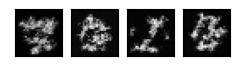

                                                                                          
Epoch 17:
Average Training Loss: 0.08917840000391007
Average Test Loss: 0.08868853800762445

                                                                                          
Epoch 18:
Average Training Loss: 0.08932638048022054
Average Test Loss: 0.0928728468183428

                                                                                          
Epoch 19:
Average Training Loss: 0.08729605610095896
Average Test Loss: 0.09065250429287552

                                                                                          
Epoch 20:
Average Training Loss: 0.08801267652289632
Average Test Loss: 0.08832227495703847



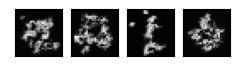

In [22]:
epochs = 20

train_losses = []
test_losses = []
    
for epoch_index in range(epochs):
    if epoch_index % 4 == 0:
        evaluate_model_results()
        
    batch_train_losses = []
    for batch_index, train_data_batch in enumerate(train_loader):
        start_time_batch = time.time()

        images, labels = train_data_batch
        images = images.to(device)
        noisy_images, timesteps, expected_noise = get_training_data_single_timestep(images, variances)
        predicted_noise = model(noisy_images, timesteps, labels)
        optimizer.zero_grad()
        loss = get_loss(predicted_noise, expected_noise)
        batch_train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        del images, noisy_images, timesteps, expected_noise, predicted_noise, loss

        if batch_index % 100 == 0:
            end_time = time.time()
            batch_time_delta = end_time - start_time_batch

            estimated_remaining_time = batch_time_delta * (amount_batches_train - (batch_index + 1))
            estimated_remaining_time = round(estimated_remaining_time)
            time_delta_formatted = datetime.timedelta(seconds=estimated_remaining_time)

            print("\r", end=f"Batch {batch_index + 1} | {amount_batches_train} ({time_delta_formatted})")

    scheduler.step()

    mean_train_loss = np.mean(batch_train_losses)
    print("\r                                                                                          ")
    print(f"Epoch {epoch_index + 1}:")
    print(f"Average Training Loss: {mean_train_loss}")
    train_losses.append(mean_train_loss)

    mean_test_loss = get_test_loss()
    test_losses.append(mean_test_loss)

evaluate_model_results()

# Evaluation

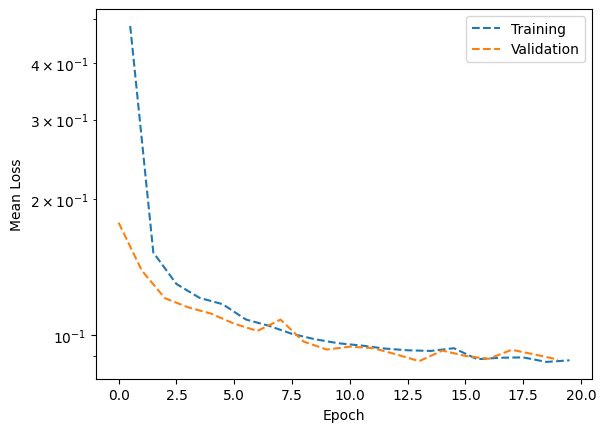

In [23]:
plt.plot(np.array(range(len(train_losses))) + 0.5, train_losses, linestyle="dashed", label="Training")
plt.plot(range(len(test_losses)), test_losses, linestyle="dashed", label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss")
plt.yscale("log")
plt.legend()

In [24]:
def plot_model_results(image, label=None, amount_columns=10):
    images = image.unsqueeze(0).to(device)
    amount_variances = variances.shape[0]
    selected_timesteps = np.linspace(1, amount_variances, amount_columns, dtype=int)

    for i, timestep in enumerate(selected_timesteps):
        selected_variances = variances[:timestep]
        plt.subplot(2, amount_columns, i + 1)
        plt.xticks([])
        plt.yticks([])
        noisy_images = add_noise(images, selected_variances).to(device)
        noisy_image_to_show = noisy_images.cpu()[0][0]
        plt.imshow(noisy_image_to_show, cmap="gray")

        plt.subplot(2, amount_columns, i + 1 + amount_columns)
        plt.xticks([])
        plt.yticks([])
        predicted_noises = model(noisy_images, torch.ones(noisy_images.shape[0]).to(device) * timestep, label)
        predicted_noise_to_show = predicted_noises.cpu()[0][0]
        plt.imshow(predicted_noise_to_show, cmap="gray")
    plt.show()

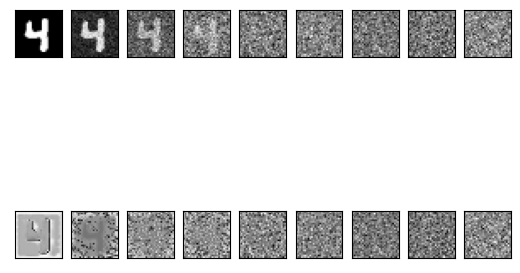

In [25]:
data_batch, labels = next(iter(train_loader))
image = data_batch[0].to(device)
label = labels[0].to(device)
with torch.no_grad():
    plot_model_results(image, label, 9)

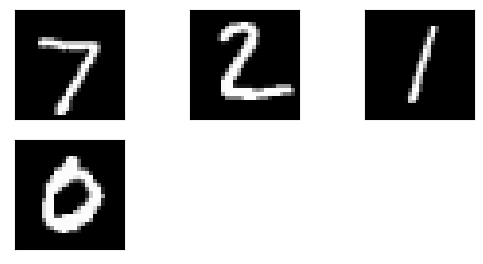

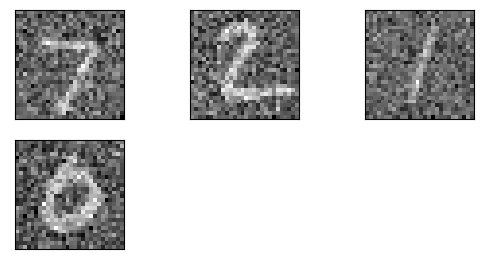

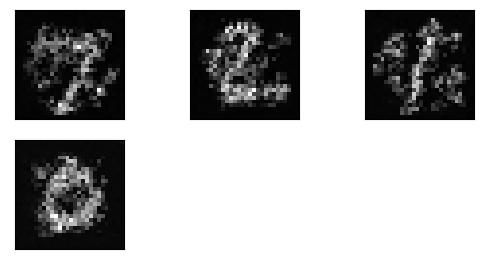

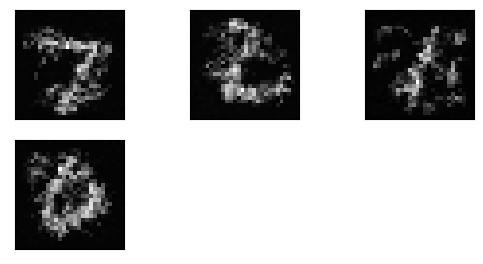

In [26]:
selected_variances = variances[:250]

sample_images, labels = next(iter(test_loader))
sample_images = sample_images[:9]
labels = labels[:9]

plot_images(sample_images.permute(0, 2, 3, 1).numpy())

noisy_images = add_noise(sample_images.to(device), selected_variances)
plot_images(noisy_images.permute(0, 2, 3, 1).cpu().numpy())

denoised_images = denoising_process(noisy_images, selected_variances, model)
plot_images(denoised_images.permute(0, 2, 3, 1).cpu().numpy())

denoised_images = denoising_process(noisy_images, selected_variances, model, labels)
plot_images(denoised_images.permute(0, 2, 3, 1).cpu().numpy())

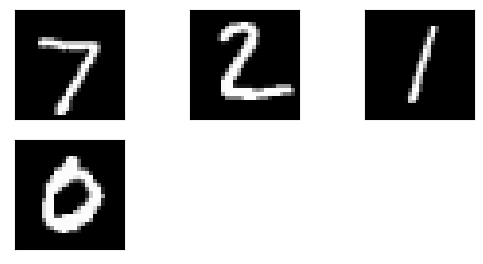

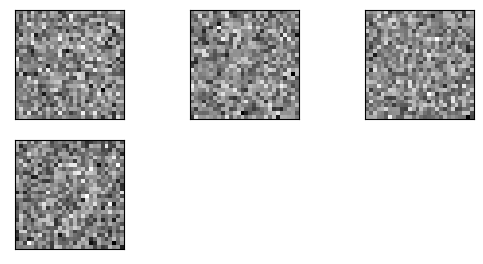

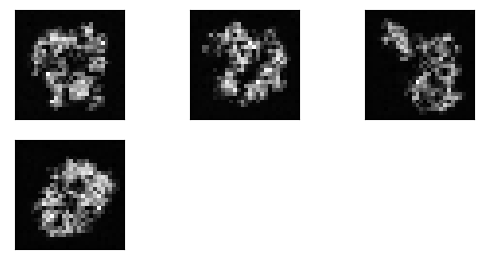

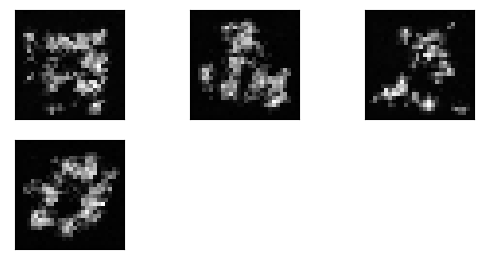

In [27]:
selected_variances = variances[:500]

sample_images, labels = next(iter(test_loader))
sample_images = sample_images[:9]
labels = labels[:9]

plot_images(sample_images.permute(0, 2, 3, 1).numpy())

noisy_images = add_noise(sample_images.to(device), selected_variances)
plot_images(noisy_images.permute(0, 2, 3, 1).cpu().numpy())

denoised_images = denoising_process(noisy_images, selected_variances, model)
plot_images(denoised_images.permute(0, 2, 3, 1).cpu().numpy())

denoised_images = denoising_process(noisy_images, selected_variances, model, labels)
plot_images(denoised_images.permute(0, 2, 3, 1).cpu().numpy())

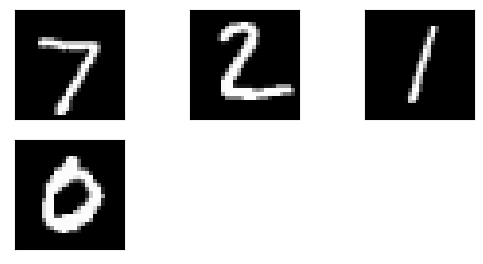

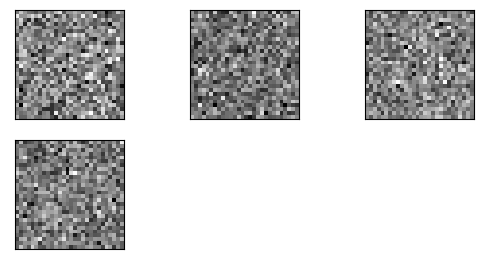

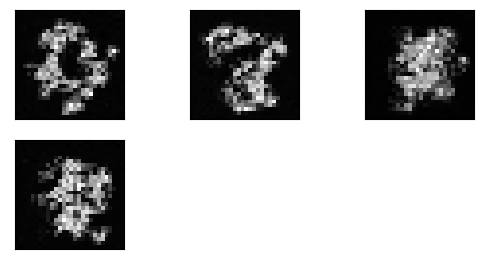

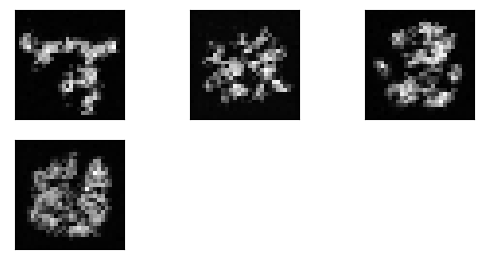

In [28]:
sample_images, labels = next(iter(test_loader))
sample_images = sample_images[:9]
labels = labels[:9]

plot_images(sample_images.permute(0, 2, 3, 1).numpy())

noisy_images = add_noise(sample_images.to(device), variances)
plot_images(noisy_images.permute(0, 2, 3, 1).cpu().numpy())

denoised_images = denoising_process(noisy_images, variances, model)
plot_images(denoised_images.permute(0, 2, 3, 1).cpu().numpy())

denoised_images = denoising_process(noisy_images, variances, model, labels)
plot_images(denoised_images.permute(0, 2, 3, 1).cpu().numpy())

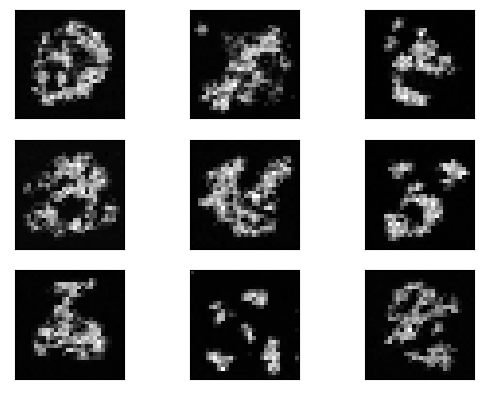

In [29]:
sample_images_size = [9, 1, 28, 28]
sample_images = torch.randn(sample_images_size).to(device)
labels = torch.tensor(range(9))
samples = denoising_process(sample_images, variances, model, labels).cpu().permute(0, 2, 3, 1).numpy()

plot_images(samples)

## FID & Inception Score

In [30]:
def get_image_generation_metrics():
    test_data = test_dataset.data
    
    if len(test_data.shape) == 3:
        test_data = test_data.reshape(test_data.shape[0], 1, test_data.shape[1], test_data.shape[2])
    
    data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    def get_generated_and_actual_images(engine, data_batch):
        with torch.no_grad():
            sample_images_size = data_batch.shape
            sample_images = torch.randn(sample_images_size).to(device)
            samples = denoising_process(sample_images, variances, model).cpu()
        
            samples = torch.cat([samples, samples, samples], dim=1)
            data_batch = torch.cat([data_batch, data_batch, data_batch], dim=1)
            
            # Resize images to 299x299
            transform = transforms.Resize(size = (299, 299))
            samples = transform(samples)
            data_batch = transform(data_batch)
        return samples, data_batch

    engine = Engine(get_generated_and_actual_images)
    
    fid = FID(device=device)
    fid.attach(engine, "fid")
    
    inception_score = InceptionScore(device=device, output_transform=lambda output: output[0])
    inception_score.attach(engine, "is")
    
    engine.run(data_loader, max_epochs=1)
    metrics = engine.state.metrics

    fid_score = metrics["fid"]
    is_score = metrics["is"]
    
    return fid_score, is_score

In [ ]:
# Note: This takes too long to run, thus it had to be interrupted. 
fid_score, is_score = get_image_generation_metrics()
print(f"   FID: {fid_score:.3e}")
print(f"   IS:  {is_score:.3e}")